# Imports

In [54]:
import numpy as np
import matplotlib.pyplot as plt

import data_visualisation as dv
from wfdb import processing

import os

# Load ECGs

In [51]:
def load_ecg(file_path):
    # Read
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize the variable to store samples per channel
    samples_per_channel = 0

    # Parse the header to find the "Samples per channel"
    for line in lines:
        if "Samples per channel" in line:
            samples_per_channel = int(line.split(':')[1].strip())
            break
        
        
    # Find the start of the data section
    data_start_idx = 0
    for i, line in enumerate(lines):
        if '[Data]' in line:
            data_start_idx = i + 1
            break
    
    # Extract the data lines
    data_lines = lines[data_start_idx:]
    
    # Parse the data lines into a list of integers
    data = []
    for line in data_lines:
        # Split line by commas and convert to integers
        leads = [int(x) for x in line.split(',') if x.strip() != '']
        leads = leads[:12]
        data.extend(leads)
        
    # format the data into a numpy array
    ecg = np.array(data).reshape(-1, 12)
    truncated_length = (ecg.shape[0] // 1000) * 1000
    truncated_ecg = ecg[:truncated_length]

    ## Downsample to 100hz
    ecg = truncated_ecg.reshape((truncated_length // 10), 12, 10)
    ecg = np.mean(ecg, axis=2)
    
    return ecg

In [52]:
# get all files in the directory

ecgs = []

for file in os.listdir("BARD"):
    if file.endswith(".txt"):
        ecg = load_ecg("BARD/" + file)
        ecgs.append(ecg)

print(len(ecgs))


717


# Normalize ECGs

In [110]:
# Normalise data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(np.concatenate(ecgs))
for i in range(len(ecgs)):
    ecgs[i] = scaler.transform(ecgs[i])
    

# Visaulaize ECGs

/tmp/ipykernel_22529/2962941323.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecg = np.random.choice(ecgs)


(1400, 12)


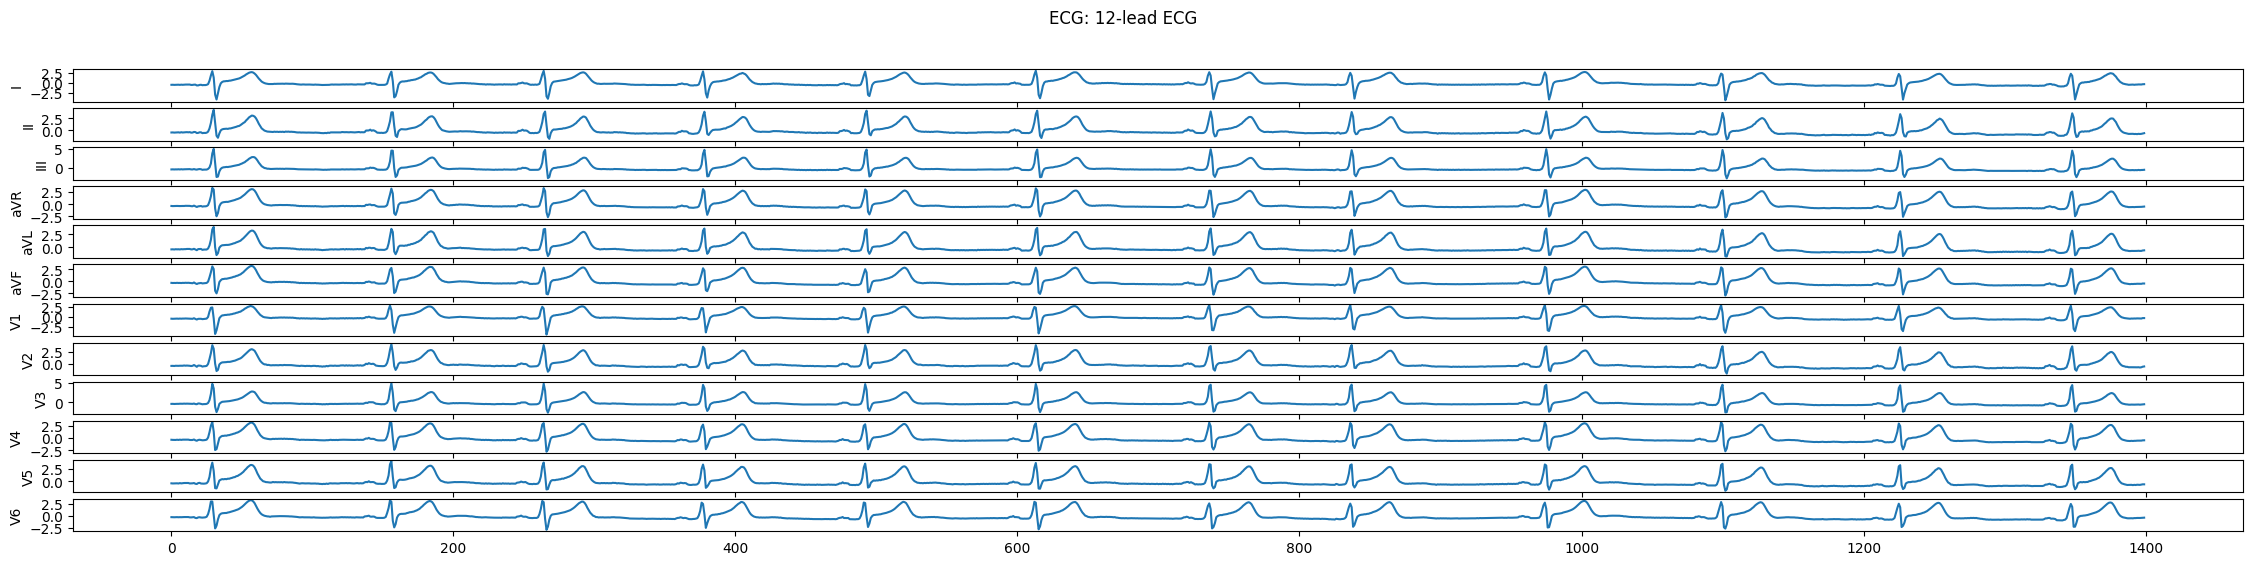

In [111]:
# get a random ecg
ecg = np.random.choice(ecgs)
print(ecg.shape)
dv.plot_12_lead_ecg(ecg, '12-lead ECG')

# Split ECGs into beats

In [92]:
def split_into_beats(X, folds=None, window_size=50):
    ecgs_HB = []
    
    for i, sample in enumerate(X):
        print("Progress:", i, "/", X.shape[0], end="\r")
        xqrs = processing.XQRS(sig=sample[:,0], fs=100)
        xqrs.detect(verbose=False)
        qrs_inds = xqrs.qrs_inds
        for indx in qrs_inds:
            if indx + window_size > sample.shape[0] or indx - window_size < 0:
                continue
            ecgs_HB.append(sample[indx-window_size:indx+window_size])
    
    return np.array(ecgs_HB)

ecgs_HB = split_into_beats(np.array(ecgs))

/tmp/ipykernel_22529/427566516.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecgs_HB = split_into_beats(np.array(ecgs))


(100, 12)


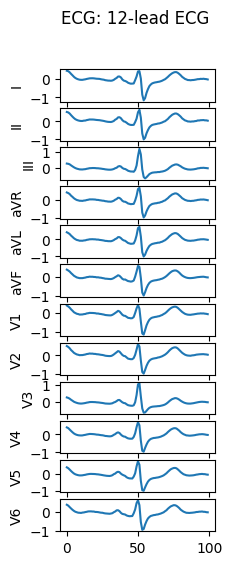

In [112]:
random_i = np.random.randint(0, ecgs_HB.shape[0])
random_ecg = ecgs_HB[random_i]
print(random_ecg.shape)
dv.plot_12_lead_ecg(random_ecg, '12-lead ECG')

In [114]:
# save
NP_PATH = "data/BARD.npz"

save_args = {
    "ecgs": ecgs,
    "ecgs_HB": ecgs_HB
}

np.savez(NP_PATH, **save_args)

/home/raaif/anaconda3/envs/FYP/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
